# Some pratical examples of Partial Rejection Sampling

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graphs" data-toc-modified-id="Graphs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graphs</a></span><ul class="toc-item"><li><span><a href="#Random-independent-set" data-toc-modified-id="Random-independent-set-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Random independent set</a></span></li><li><span><a href="#Uniform-sink-free-graph" data-toc-modified-id="Uniform-sink-free-graph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Uniform sink-free graph</a></span></li><li><span><a href="#Rooted-spanning-forest" data-toc-modified-id="Rooted-spanning-forest-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Rooted spanning forest</a></span></li></ul></li><li><span><a href="#PRS-for-2D-hard-core-model" data-toc-modified-id="PRS-for-2D-hard-core-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PRS for 2D hard-core model</a></span></li><li><span><a href="#Dominated-CFTP" data-toc-modified-id="Dominated-CFTP-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dominated CFTP</a></span><ul class="toc-item"><li><span><a href="#Strauss-process" data-toc-modified-id="Strauss-process-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Strauss process</a></span></li></ul></li><li><span><a href="#Grid-PRS-for-Gibbs-process-(Moka-&amp;-Kroese)" data-toc-modified-id="Grid-PRS-for-Gibbs-process-(Moka-&amp;-Kroese)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grid PRS for Gibbs process (Moka &amp; Kroese)</a></span><ul class="toc-item"><li><span><a href="#Application-to-Strauss-process" data-toc-modified-id="Application-to-Strauss-process-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Application to Strauss process</a></span></li></ul></li><li><span><a href="#Old-shit" data-toc-modified-id="Old-shit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Old shit</a></span><ul class="toc-item"><li><span><a href="#Some-chess-graphs" data-toc-modified-id="Some-chess-graphs-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Some chess graphs</a></span></li></ul></li></ul></div>

In [1]:
using LinearAlgebra
const LA = LinearAlgebra

using SparseArrays
const SA = SparseArrays

using Random
using Distributions

getRNG(seed::Integer=-1) = seed >= 0 ? Random.MersenneTwister(seed) : Random.GLOBAL_RNG
getRNG(seed::Union{Random.MersenneTwister, Random._GLOBAL_RNG}) = seed

using Plots

using LightGraphs
const LG = LightGraphs

using SimpleWeightedGraphs
const SWG = SimpleWeightedGraphs

using GraphPlot, Colors
edgemap(g::LG.AbstractGraph) = Dict(LG.edges(g) .=> 1:LG.ne(g))
# Dict{LG.Edge, Int}(e => i for (i, e) in enumerate(LG.edges(g)))

using Distances: pairwise, Euclidean

## Graphs

Construct a connected graph

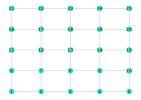

In [2]:
width, height = 10, 8
width, height = 5, 5

g = LG.grid((width, height))

pos = collect(Iterators.product(1:height, 1:width))[:]
locs_x, locs_y = map(x->x[1], pos), map(x->x[2], pos)

gplot(g, 
    locs_x, reverse(locs_y),
    nodelabel=LG.vertices(g))

### Random independent set

In [3]:
"""
Sample independent set of vertices of a graph
Moka, Kroese
https://arxiv.org/pdf/1901.05624.pdf
"""
function sample_independent_set(graph::LG.SimpleGraph{T}, proba::Float64; rng=-1) where T
    
    !(0.0 <= proba < 1.0) && throw(DomainError(proba, "proba ∉ [0, 1)"))    
    proba == 0.0 && return falses(LG.nv(graph))
    
    rng = getRNG(rng)
    adj = LG.adjacency_matrix(graph)
    occup = randsubseq(rng, LG.vertices(graph), proba)

    while true

        # Check if occup vertices form an independent set
        # SA.nnz(adj[occup, occup]) == 0 && break
        sub_graph = LG.SimpleGraph(adj[occup, occup])
        LG.ne(sub_graph) == 0 && break
        
        # Identify current independent vertices
        # and construct resampling set of vertices
        ind, res = T[], Set{T}()
        for cc in LG.connected_components(sub_graph)
            if length(cc) == 1
                append!(ind, occup[cc])
            else
                union!(res, occup[cc])
                for v in cc
                    union!(res, LG.neighbors(graph, occup[v]))
                end
            end
        end
        randsubseq!(rng, occup, collect(res), proba)
        append!(occup, ind)

    end    
    
    return occup
                
end

sample_independent_set

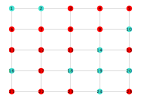

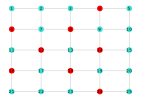

Random independent set


In [4]:
# ν = 0.5; proba = ν / (1 + ν)
proba = 0.6
seed = 0

width, height = 5, 5
g = LG.grid((width, height))

# initial configuration
occ_init = rand(getRNG(seed), LG.nv(g)) .< proba 

col_nodes = [colorant"turquoise" for _ in 1:LG.nv(g)]
col_nodes[occ_init] .= colorant"red"

p = gplot(g, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g),
    nodefillc=col_nodes,
#     arrowlengthfrac=0.05
#     edgestrokec=col_edges
)

display(p)

println("Random independent set")

# random independent set
occ = sample_independent_set(g, proba, rng=seed)

col_nodes = [colorant"turquoise" for _ in 1:LG.nv(g)]
col_nodes[occ] .= colorant"red"

p = gplot(g, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g),
    nodefillc=col_nodes,
#     arrowlengthfrac=0.05
#     edgestrokec=col_edges
)
display(p)

### Uniform sink-free graph

In [5]:
sink_nodes(g::LG.SimpleDiGraph) = [v for v in LG.vertices(g) if LG.outdegree(g, v) == 0]

function random_edge_orientation(graph::LG.SimpleGraph; rng=-1)::LG.SimpleDiGraph
    rng = getRNG(rng)
    return LG.SimpleDiGraphFromIterator(rand(rng) < 0.5 ? e : reverse(e) for e in LG.edges(graph))
end

"""
Sample sink free orientation of a graph using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1611.01647.pdf
"""
function sample_sink_free_orientation(graph::LG.SimpleGraph; rng=-1)::LG.SimpleDiGraph
    
    rng = getRNG(rng)
    g = random_edge_orientation(graph, rng=rng)

    it = 0
    while true
        sinks = sink_nodes(g)
        isempty(sinks) && break
            
        # Resample i.e. flip edges forming a sink with probability 0.5
        for v in sinks
            for w in LG.inneighbors(g, v)
                if rand(rng) < 0.5
                    LG.rem_edge!(g, w, v)
                    LG.add_edge!(g, v, w)
                end
            end
        end
        it += 1
    end

    return g
end

function color_sinks(graph)

    nodes = []
    edge_idx = []
    
    edge_map = edgemap(graph)
    
    for v in LG.vertices(graph)
        if LG.outdegree(graph, v) == 0
            push!(nodes, v)
            for w in LG.inneighbors(graph, v)
                push!(edge_idx, edge_map[LG.Edge(w, v)])
            end
        end
    end

    col_nodes = [colorant"turquoise" for _ in 1:LG.nv(graph)]
    col_nodes[nodes] .= colorant"red"
    
    col_edges = [colorant"lightgray" for _ in 1:LG.ne(graph)]
    col_edges[edge_idx] .= colorant"red"
    
    return col_nodes, col_edges
    
end

color_sinks (generic function with 1 method)

Consider a random orientation of the edges of the graph.

Apply the uniform sink free sampler, based on partial rejection sampling.

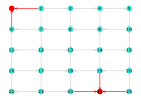

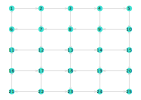

Sink free orientation


In [6]:
seed = 0

width, height = 5, 5
g = LG.grid((width, height))

g_oriented = random_edge_orientation(g, rng=seed)
col_nodes, col_edges = color_sinks(g_oriented)
p = gplot(g_oriented, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g_oriented),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05
)
display(p)

println("Sink free orientation")

g_sink_free = sample_sink_free_orientation(g, rng=seed)
cols = [LG.outdegree(g_sink_free, v) == 0 ? colorant"red" : colorant"turquoise" 
        for v in LG.vertices(g_sink_free)]
p = gplot(g_sink_free, 
    locs_x, locs_y,
    nodelabel=LG.vertices(g_sink_free),
    nodefillc=cols,
    arrowlengthfrac=0.05
)
display(p)

### Rooted spanning forest

In [7]:
function random_neighbor_assignment(graph::LG.SimpleGraph, roots::Array{Int64,1}; rng=-1)::LG.SimpleDiGraph
    rng = getRNG(rng)
    edges = [(v, rand(rng, LG.neighbors(graph, v))) for v in LG.vertices(graph) if v ∉ roots]
    return LG.SimpleDiGraph(LG.Edge.(edges))
end

"""
Sample rooted spanning forest using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1611.01647.pdf
"""
function rooted_spanning_forest(graph::LG.SimpleGraph, roots::Array{Int64,1}; rng=-1)::LG.SimpleDiGraph
    
    rng = getRNG(rng)
    g = random_neighbor_assignment(graph, roots, rng=rng)

    while true
        vertices_in_cycles = Set(Iterators.flatten(LG.simplecycles(g)))
        isempty(vertices_in_cycles) && break

        # Resample the successor of vertices involved in cycles
        for v in vertices_in_cycles      
            # Remove current edge (v, w)
            w = LG.neighbors(g, v)[1]
            LG.rem_edge!(g, v, w)      
            # Resample the successor w of v and add edge (v, w)
            w = rand(rng, LG.neighbors(graph, v))
            LG.add_edge!(g, v, w)
        end
    end
                
    return g
end

function rooted_spanning_tree(graph::LG.SimpleGraph, root::Int64; rng=-1)::LG.SimpleDiGraph
    return rooted_spanning_forest(graph, [root], rng=rng)
end

function color_cycles(graph::LG.SimpleDiGraph)

    edge_map = edgemap(graph)
    edge_idx = []
    
    nodes = Set{eltype(graph)}()
    
    for cycle in LG.simplecycles(graph)
        union!(nodes, cycle)
        for (x, y) in zip(cycle, circshift(cycle, -1))
            push!(edge_idx, edge_map[LG.Edge(x, y)])
        end
    end

    col_nodes = [colorant"turquoise" for _ in 1:LG.nv(graph)]
    col_nodes[collect(nodes)] .= colorant"red"
    
    col_edges = [colorant"lightgray" for _ in 1:LG.ne(graph)]
    col_edges[edge_idx] .= colorant"red"
    
    return col_nodes, col_edges
    
end

color_cycles (generic function with 1 method)

Assign a random neighbor to each vertex of the graph.

Apply the uniform rooted spanning forest sampler, based on partial rejection sampling.

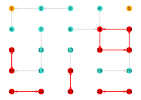

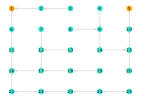

In [8]:
seed = 10

roots = [1, 5]
width, height = 5, 5
g = LG.grid((width, height))

g_oriented = random_neighbor_assignment(g, roots, rng=seed)
col_nodes, col_edges = color_cycles(g_oriented)
col_nodes[roots] .= colorant"orange"

p = gplot(g_oriented, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g_oriented),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05,
)
title!("Random neighbor assignment")
display(p)

ust = rooted_spanning_forest(g, roots, rng=seed)
col_nodes, col_edges = color_cycles(ust)
col_nodes[roots] .= colorant"orange"

p = gplot(ust, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(ust),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05,
)
title!("Sink free orientation")
display(p)

## PRS for 2D hard-core model

H. Guo, M. Jerrum "Perfect simulation of the Hard Disks Model by Partial Rejection Sampling"
https://arxiv.org/abs/1801.07342

In [9]:
"""
Sample n points uniformly in B(c, r) (disk of radius r centered at c)
"""
function sample_in_disk(n, r, c; rng=-1)
    rng = getRNG(rng)
    rad = r * sqrt.(rand(rng, 1, n))
    theta = 2π .* rand(rng, 1, n)
    return c .+ rad .* vcat(cos.(theta), sin.(theta))
end

pairwise_distances(X, Y) = pairwise(Euclidean(1e-8), X, Y, dims=2)
    
function pairwise_distances(X)
    dist = pairwise_distances(X, X)
    dist[LA.diagind(dist)] .= Inf
    return dist
end
    
"""
Sample from Poisson(λ) on ⋃ᵢ B(cᵢ, r) (union of disks of radius r centered at cᵢ)
Use the independence property of the Poisson point process
- Sample from Poisson(λ) on B(c₁, r)
- Sample from Poisson(λ) on B(c₂, r) ∖ B(c₁, r)
- Sample from Poisson(λ) on B(cⱼ, r) ∖ ⋃_i<j B(cᵢ, r)
"""
function poisson_disks(λ, r, centers; rng=-1)
    rng = getRNG(rng)
    
    𝒫 = Poisson(λ * π * r^2)
    n = rand(rng, 𝒫)
    sample = sample_in_disk(n, r, centers[:, 1], rng=rng)
    
    for (i, c) in enumerate(eachcol(centers[:, 2:end]))
        
        n = rand(rng, 𝒫)
        prop = sample_in_disk(n, r, c, rng=rng)

        isempty(prop) && continue
        acc = vec(all(pairwise_distances(centers[:, 1:i], prop) .> r, dims=1))
        
        sample = hcat(sample, prop[:, acc])
    
    end
        
    return sample
end

"""
Sample from spatial hard core model a.k.a Poisson disk sampling 
with intensity λ and radius r on [0, 1]^2, using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1801.07342.pdf
"""
function sample_hard_core_prs(λ, r; rng=-1)

    rng = getRNG(rng)
    n = rand(rng, Poisson(λ))
    points = rand(rng, 2, n)
    
    while true
        bad = vec(any(pairwise_distances(points) .< 2r, dims=2))
        !any(bad) && break

        resampled = poisson_disks(λ, 2r, points[:, bad], rng=rng)
        points = hcat(points[:, .!bad], resampled)
    end

    return points     
end

sample_hard_core_prs

In [10]:
seed = 0
# r = radius of the ball, 2r = interaction range
λ₀, r = 0.3, 1/200  
λ = λ₀ / (π * r^2)
points = sample_hard_core_prs(λ, r, rng=seed);

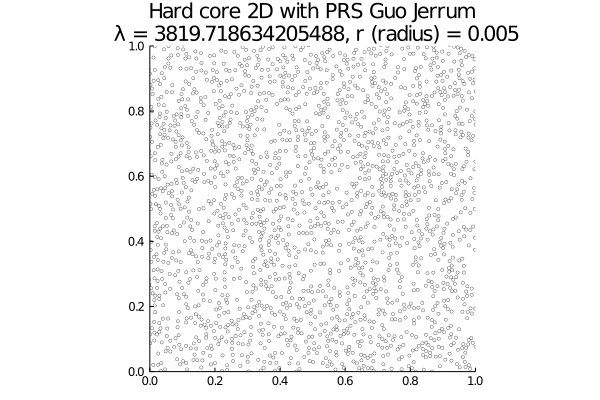

In [11]:
θ = collect(range(0, 2π, length=15))
circ_x, circ_y = r .* cos.(θ), r .* sin.(θ);

p = plot(points[1, 1] .+ circ_x, points[2, 1] .+ circ_y,
         aspect_ratio=:equal,
         legend=false, color="black", 
         linewidth=0.3, 
         grid=:none,
        title="Hard core 2D with PRS Guo Jerrum\n λ = $(λ), r (radius) = $(r)")
for (x, y) in eachcol(points[:, 2:end])
    plot!(x .+ circ_x, y .+ circ_y, 
          label="", color="black", linewidth=0.3)
end
xlims!((0, 1))
ylims!((0, 1))
display(p)

## Dominated CFTP

Apply dominated CFTP 
- [Kendall \& Moller's orginal formulation of dCFTP](https://www.researchgate.net/publication/2821877_Perfect_Metropolis-Hastings_simulation_of_locally_stable_point_processes)
- Huber, Perfect Simulation
- [Kendall's notes on perfect simulation](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/kendall/personal/ppt/428.pdf) 

### Strauss process

$\beta > 0$, $0\leq \gamma\leq 1, r > 0$

$$
\mathbb{P}[\mathcal{X}=X]
\propto
\beta^{|X|} \gamma^{|\{\{x, y\} ~;~ \operatorname{distance}(x, y) \leq r, \text{ and } x \neq y \in X\}|}
$$

$\gamma = 0$ corresponds to a hardcore model.

This serves as a building block of the grid PRS technique of Moka and Kroese

In [12]:
function distance(x, y)
    return sqrt((y[1] - x[1])^2 + (y[2] - x[2])^2)
end

function backward_update_strauss!(D::Set{Array{T,1}},  # Dominating process
                                  M::Array{T,1},  # Mark process
                                  R::Array{Array{T,1},1},  # Recording process
                                  n::Int64,  # Number of backward steps
                                  β::T;
                                  c=[0.0, 0.0], 
                                  w=[1.0, 1.0], 
                                  rng=-1) where T<:Float64
    @assert β > 0.0

    rng = getRNG(rng)
    b_rate = β * prod(w)
    
    for _ in 1:n
        card_D = length(D)
        if rand(rng) < card_D / (b_rate + card_D)
            # forward death ≡ backward birth
            x = rand(rng, D)
            setdiff!(D, [x])
            pushfirst!(R, x)
            pushfirst!(M, rand(rng))
        else
            # forward birth ≡ backward death
            x = c .+ w .* rand(rng, 2)
            union!(D, [x])
            pushfirst!(R, x)
            pushfirst!(M, 0.0)
        end
    end
    
    return D, M, R
end

function forward_coupling_strauss(D::Set{Array{T,1}},  # Dominating process
                                  M::Array{T,1},  # Mark process
                                  R::Array{Array{T,1},1},  # Recording process
                                  γ::T, 
                                  r::T) where T<:Float64
    
    @assert 0.0 <= γ <= 1.0
    @assert r > 0.0
    
    # L ⊆ X ⊆ U ⊆ D, where X is the target process
    L, U = typeof(D)(), copy(D)
    log_γ = log(γ)
    
    for (m, x) in zip(M, R)
        in_neighborhood_of_x = y -> distance(x, y) <= r
        if m > 0.0
            log_m = log(m)
            neigh_U = count(in_neighborhood_of_x, U)
            if neigh_U == 0 || log_m < neigh_U * log_γ
                union!(L, [x])
                union!(U, [x])
            else
                neigh_L = count(in_neighborhood_of_x, L)
                if neigh_U == 0 || log_m < neigh_L * log_γ
                    union!(U, [x])
                end
            end
        else
            setdiff!(L, [x])
            setdiff!(U, [x])
        end
    end
    
    return L, U
end

function sample_strauss_dcftp(β::T,
                              γ::T, 
                              r::T;
                              c=[0.0, 0.0], # SW corner of the window
                              w=[1.0, 1.0], # x, y width of the window
                              rng=-1) where T<:Float64
    
    @assert β > 0.0
    @assert 0.0 <= γ <= 1.0
    @assert r > 0.0
    rng = getRNG(rng)
    
    k = rand(rng, Poisson(β * prod(w)))
    D = Set{Array{T, 1}}(c .+ w .* rand(rng, 2) for _ in 1:k)  # Dominating process
    M = T[]  # Mark process
    R = Array{T, 1}[]  # Recording process

    n = 1
    while true
        D, M, R = backward_update_strauss!(D, M, R, n, β, c=c, w=w, rng=rng)
        L, U = forward_coupling_strauss(D, M, R, γ, r)
        # Check coalescence L = U (Since L ⊆ U: L = U ⟺ |L| = |U|)
        length(L) == length(U) && return collect(L)
        n *= 2
    end
                             
end

sample_strauss_dcftp (generic function with 1 method)

Experimental setup refers to s.9 of [E. Rubak](https://www-ljk.imag.fr/membres/Jean-Francois.Coeurjolly/documents/lecture4.pdf)

In [13]:
β, γ, r = 2.0, 0.2, 0.7  # interaction range = 2*radius
# Window
# - c : South-West corner
# - w : width along x and y axes
c, w = [0.0, 0.0], [10.0, 10.0]
seed = 0
points = sample_strauss_dcftp(β, γ, r, c=c, w=w, rng=seed);

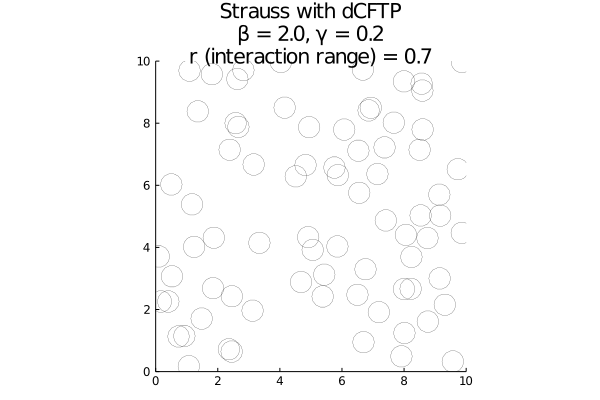

In [14]:
θ = collect(range(0, 2π, length=15))
rad = r / 2  # radius = interaction range / 2
circ_x, circ_y = rad .* cos.(θ), rad .* sin.(θ)

disp = plot([0], [0], 
              label="", legend=false,
              color="white", 
              linewidth=0.0, 
              aspect_ratio=:equal,
              grid=:none,
            title="Strauss with dCFTP\nβ = $(β), γ = $(γ)\nr (interaction range) = $(r)")


for p in points
    plot!(p[1] .+ circ_x, p[2] .+ circ_y,
          color="black", linewidth=0.2)
end

xlims!((c[1], w[1]))
ylims!((c[2], w[2]))
display(disp)

In [15]:
γ = 0.0
r = 0.01  # interaction range = 2*radius
β₀ = 0.3
β = β₀ / (π * (r/2)^2)

c, w = [0.0, 0.0], [1.0, 1.0]
seed = -1
points = sample_strauss_dcftp(β, γ, r, c=c, w=w, rng=seed);

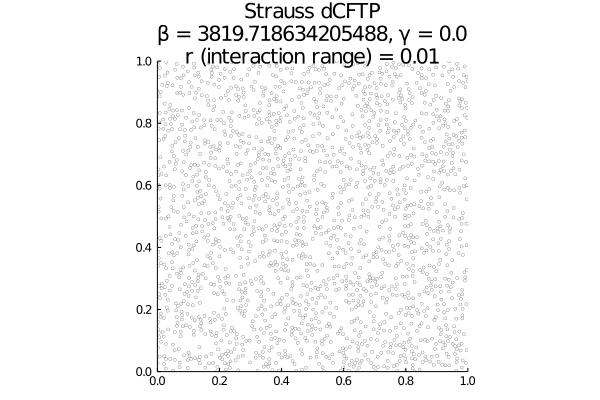

In [16]:
θ = collect(range(0, 2π, length=15))
rad = r / 2  # radius = interaction range / 2
circ_x, circ_y = rad .* cos.(θ), rad .* sin.(θ)

disp = plot([0], [0], 
              label="", legend=false,
              color="white", 
              linewidth=0.0, 
              aspect_ratio=:equal,
              grid=:none,
            title="Strauss dCFTP\nβ = $(β), γ = $(γ)\nr (interaction range) = $(r)")

for p in points
    plot!(p[1] .+ circ_x, p[2] .+ circ_y,
          color="black", linewidth=0.2)
end

xlims!((c[1], w[1]))
ylims!((c[2], w[2]))
display(disp)

## Grid PRS for Gibbs process (Moka \& Kroese)
Moka, Sarat B. and Kroese, Dirk P. (2020). 
Perfect sampling for Gibbs point processes using partial rejection sampling.
https://espace.library.uq.edu.au/view/UQ:d924abb

### Application to Strauss process

###### Dependency graph

The configuration of each cell $C_i$ depends on its direct neighbors.

Each edge $\{i, j\}$ is associated to an event and marked with a uniform random variable $U_{ij}$.

The "bad" event associated to edge $\{i, j\}$ corresponds to 
$$\left\{U_{i,j} > \gamma^{\#\{\{x, y\} ~;~ \operatorname{distance}(x, y) < r,~x \in C_i,~y \in C_j\}}\right\}$$

In [17]:
function distance(x, y)
    return sqrt((y[1] - x[1])^2 + (y[2] - x[2])^2)
end

function count_overlaps(c1, c2, r)
    (isempty(c1) || isempty(c2)) && return 0
    return sum(sum(distance(x, y) < r for x in c2) for y in c1)
end

"""
Assuming Cᵢ and Cⱼ are neighboring cells, 
check whether an assignment of Cⱼ can induce a bad event
i.e. distance(Cᵢ, Cⱼ) < r
"""
function is_extension_possible(cells, i, j, r)::Bool
    isempty(cells[i]) && return false

    k = ceil(Int, 1.0 / r)
    yi, xi = divrem(i-1, k)
    yj, xj = divrem(j-1, k)
    
    # If i-j is a vertical or horizontal neighborhood
    (xi == xj || yi == yj) && return true
    
    # If i-j is a diagonal neighborhood
    corner_ij = r .* [xi + xi < xj, yi + yi < yj]
    return any(distance(corner_ij, p) < r for p in cells[i])
end

"""
Return the strong product of a graph with itself
[strong product](https://en.wikipedia.org/wiki/Strong_product_of_graphs)

See also:
Section 5 of https://drops.dagstuhl.de/opus/volltexte/2019/11538/pdf/LIPIcs-ISAAC-2019-42.pdf
"""
function strong_product(g::G)::G where G<:LG.AbstractGraph
    
    n = LG.nv(g)
    sp_gg = G(n * n) # nv = n^2, ne = 2n(2n+1)
    
    id(i, j) = (i - 1) * n + j
    
    for e1 in LG.edges(g)
        i1, i2 = Tuple(e1)
        for j in LG.vertices(g)
            LG.add_edge!(sp_gg, id(i1, j), id(i2, j))
            LG.add_edge!(sp_gg, id(j, i1), id(j, i2))
        end
        for e2 in LG.edges(g)
            j1, j2 = Tuple(e2)
            LG.add_edge!(sp_gg, id(i1, j1), id(i2, j2))
            LG.add_edge!(sp_gg, id(i1, j2), id(i2, j1))
        end
    end
    
    return sp_gg
end

king_graph(k::Int64) = strong_product(LG.path_graph(k))

@doc raw"""
The dependency graph between the cells is a weighted king graph 
where each edge $\{i,j\}$ is associated to an event and carries a uniform mark $U_{ij}$.
Note https://en.wikipedia.org/wiki/King%27s_graph
"""
function dependency_graph(r::Float64; rng=-1)::SWG.SimpleWeightedGraph{Int64, Float64}
    
    rng = getRNG(rng)
    
    k = ceil(Int, 1.0 / r)
    
    king = SWG.SimpleWeightedGraph(king_graph(k))
    for e in LG.edges(king)
        i, j = Tuple(e)
        @inbounds king.weights[i, j] = king.weights[j, i] = rand(rng)
    end

    return king
end

@doc raw"""
Identify bad events and return the corresponding cells' index.
A bad event corresponds to
$$
\left\{U_{ij} > \gamma^{\#\{\{x, y\} ~;~ \operatorname{distance}(x, y) < r,~x \in C_i,~y \in C_j\}}\right\}
$$
where $U_{ij}$ is stored as the weight of edge $\{i,j\}$ in the dependency graph $g$.
Note: when a bad event occurs, the corresponding U_{ij} is resampled hence the "!"
"""
function indices_bad_cells!(g, cells, γ, r; rng=-1)
    rng = getRNG(rng)
    ind_bad = Set{Int64}()
    for e ∈ LG.edges(g)
        i, j = Tuple(e)
        nb_overlaps = count_overlaps(cells[i], cells[j], r)
        if e.weight > γ ^ nb_overlaps
            union!(ind_bad, [i, j])
            # resample U_ij associated to the event bad
            @inbounds g.weights[i, j] = g.weights[j, i] = rand(rng)
        end
    end
    return ind_bad
end

"""
Identify which events need to be resampled and return the corresponding cells' index.
This is the core of the Partial Rejection Sampling algorithm.
Note: when a event needs to be resampled, the corresponding mark U_{ij} is resampled hence the "!"
"""
function indices_cells_to_resample!(g, cells, γ, r; rng=-1)
    rng = getRNG(rng)
    R = indices_bad_cells!(g, cells, γ, r, rng=rng)
    ∂R, ∂R_tmp = copy(R), Set{Int64}()
    while !isempty(∂R)
        for i ∈ ∂R
            isempty(cells[i]) && continue
            for j ∈ LG.neighbors(g, i)
                if j ∉ R && is_extension_possible(cells, i, j, r)
                    union!(R, j)
                    union!(∂R_tmp, j)
                    # resample U_ij associted to event {i,j}
                    @inbounds g.weights[i, j] = g.weights[j, i] = rand(rng)
                end
            end
        end
        ∂R, ∂R_tmp = ∂R_tmp, Set{Int64}()
    end
    return R
end

"""
Sample the content of the cells indexed by `res_ind`
"""
function sample_cells_strauss!(cells, res_ind, β, γ, r; rng=-1)
    rng = getRNG(rng)
    k = ceil(Int, 1.0 / r)
    for i in res_ind
        c_y, c_x = divrem(i-1, k)
        c = r .* [c_x, c_y]  # coordinates of bottom left corner of the cell
        w = min.(r, 1.0 .- c) # x and y width of the cell
        cells[i] = sample_strauss_dcftp(β, γ, r, c=c, w=w, rng=rng)
    end
end

"""
Grid Partial Rejection Sampling for the Strauss point process
Moka, Sarat B. and Kroese, Dirk P. (2020). 
https://espace.library.uq.edu.au/view/UQ:d924abb
"""
function sample_strauss_grid_prs(β, γ, r; rng=-1)
    @assert β > 0.0
    @assert 0.0 <= γ <= 1.0
    @assert r > 0.0
    
    rng = getRNG(rng)
    g = dependency_graph(r, rng=rng)
    
    res = 1:LG.nv(g)
    cells = [Array{Float64,1}[] for _ in res]
    
    while !isempty(res)
        sample_cells_strauss!(cells, res, β, γ, r, rng=rng)
        res = indices_cells_to_resample!(g, cells , γ, r, rng=rng)
    end
    
    points = vcat(filter(!isempty, cells)...)
    return points
end

sample_strauss_grid_prs

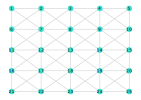

In [18]:
r = 1 / 5
g = dependency_graph(r)

k = ceil(Int, 1.0 / r)
pos = collect(Iterators.product(1:k, 1:k))[:]
locs_x, locs_y = map(x->x[1], pos), map(x->x[2], pos)

gp = gplot(g, 
    locs_x, locs_y,
    nodelabel=LG.vertices(g))

In [19]:
γ = 0.0  # 0.0 = hard core
r = 0.01  # interaction range = 2*radius
β₀ = 0.3
β = β₀ / (π * (r/2)^2)
seed = -1

points = sample_strauss_grid_prs(β, γ, r; rng=seed);

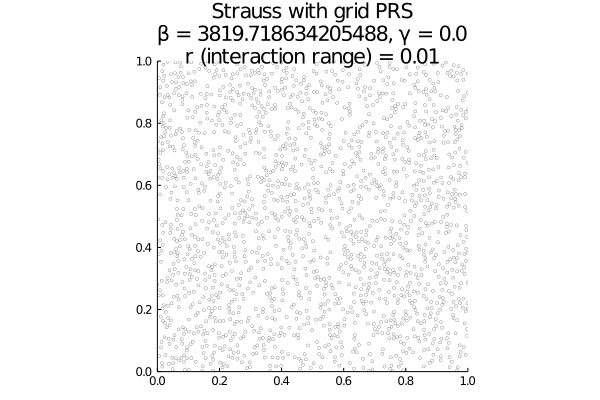

In [20]:
θ = collect(range(0, 2π, length=15))
rad = r/2  # interaction range / 2
circ_x, circ_y = rad .* cos.(θ), rad .* sin.(θ)

disp = plot([0], [0], 
              label="", legend=false,
              color="white", 
              linewidth=0.0, 
              aspect_ratio=:equal,
              grid=:none,
            title="Strauss with grid PRS\nβ = $(β), γ = $(γ)\nr (interaction range) = $(r)")
for p in points
    plot!(p[1] .+ circ_x, p[2] .+ circ_y,
          color="black", linewidth=0.2)
end

xlims!((0, 1))
ylims!((0, 1))
display(disp)

## Old shit

### Some chess graphs

The depency graph of the cells is a 
[king graph](https://en.wikipedia.org/wiki/King%27s_graph) which can be constructed as a strong product between two path graphs.

In [21]:
# function strong_product_v0(g::G, h::G) where G <: LG.AbstractGraph   
#     cp = LG.cartesian_product(g, h)
#     tp = LG.tensor_product(g, h)
#     return LG.union(cp, tp)
# end

# function strong_product_v1(g::G, h::G) where G <: LG.AbstractGraph
#     z = G(LG.nv(g) * LG.nv(h))
#     id(i, j) = (i - 1) * LG.nv(h) + j
    
#     for e1 in LG.edges(g)
#         i1, i2 = Tuple(e1)
#         for j = 1:nv(h)
#             LG.add_edge!(z, id(i1, j), id(i2, j))
#         end
#         for e2 in LG.edges(h)
#             j1, j2 = Tuple(e2)
#             LG.add_edge!(z, id(i1, j1), id(i2, j2))
#             LG.add_edge!(z, id(i1, j2), id(i2, j1))
#         end
#     end

#     for e in LG.edges(h)
#         j1, j2 = Tuple(e)
#         for i in LG.vertices(g)
#             LG.add_edge!(z, id(i, j1), id(i, j2))
#         end
#     end

#     return z
# end

# function strong_product_v3(g::G, h::G) where G <: LG.AbstractGraph
#     Ā_g = LG.adjacency_matrix(g)
#     Ā_g[LA.diagind(Ā_g)] .= 1
    
#     if g == h
#         A_sp = LA.kron(Ā_g, Ā_g)
#     else
#         Ā_h = LG.adjacency_matrix(h)
#         Ā_h[LA.diagind(Ā_h)] .= 1
#         A_sp = LA.kron(Ā_g, Ā_h)
#     end

#     A_sp[LA.diagind(A_sp)] .= 0
    
#     return G(A_sp)
# end

# """Construct of the king's graph 
# https://drops.dagstuhl.de/opus/volltexte/2019/11538/pdf/LIPIcs-ISAAC-2019-42.pdf
# """
# king_graph(w, h) = strong_product_v1(LG.path_graph(h), LG.path_graph(w))

# """Bishop's graph: union of black and white bishops' graph
# """
# function bishop_graph(w, h)
#     tmp = ones(Int64, w-1)
#     block_w = SA.spdiagm(-1=>tmp, 1=>tmp)
    
#     if w == h
#         adj = LA.kron(block_w, block_w)
#     else
#         tmp = ones(Int64, h-1)
#         block_h = SA.spdiagm(-1=>tmp, 1=>tmp)
#         adj = LA.kron(block_h, block_w)
#     end
    
#     return LG.SimpleGraph(adj)
# end

# """Rook graph a.k.a LG.grid((w, h)) grid graph
# """
# function rook_graph(w, h)
#     tmp = ones(Int64, w - 1)
#     block_w = SA.spdiagm(-1=>tmp, 1=>tmp)
#     I_w = SA.sparse(I, w, w)
    
#     if w == h
#         adj = LA.kron(I_w, block_w) + LA.kron(block_w, I_w)
#     else
#         tmp = ones(Int64, h - 1)
#         block_h = SA.spdiagm(-1=>tmp, 1=>tmp)
#         I_h = SA.sparse(I, h, h)

#         adj = LA.kron(I_h, block_w) + LA.kron(block_h, I_w)
#     end
    
#     return LG.SimpleGraph(adj)
# end

# king_graph_v0(w, h) = strong_product_v0(LG.path_graph(h), LG.path_graph(w))
# king_graph_v1(w, h) = strong_product_v1(LG.path_graph(h), LG.path_graph(w))
# king_graph_v2(w, h) = strong_product_v2(LG.path_graph(h), LG.path_graph(w))
# king_graph_v3(w, h) = strong_product_v3(LG.path_graph(h), LG.path_graph(w))